# Cluster Analysis: Lexico-grammatical style (S. 5.2)

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import heapq

from numpy.typing import NDArray
from typing import Callable, Collection, Union

from sklearn.preprocessing import Normalizer, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier

from ruzicka.test_metrics import nini, minmax, cosine

In [2]:
%load_ext rpy2.ipython

In [3]:
vecs = pd.read_csv("elegy_poetic.csv", index_col=0)

In [4]:
vecs

,Author,Work,Poem,H1SP,H2SP,H3SP,H4SP,H1CF,H2CF,H3CF,...,P4SC,P1WC,P2WC,P3WC,P4WC,ELC,RS,LEO,LEN,PFSD
0,Ovid,Ep.,Ep. 1,0.086207,0.500000,0.500000,0.448276,0.241379,0.706897,0.810345,...,0.0,0.206897,0.068966,0.396552,1.000000,0.094828,4.393948,0.739842,116,0.000000
1,Ovid,Ep.,Ep. 2,0.189189,0.527027,0.581081,0.391892,0.283784,0.743243,0.878378,...,0.0,0.202703,0.067568,0.337838,1.000000,0.114865,4.071062,1.027448,148,0.000000
2,Ovid,Ep.,Ep. 3,0.220779,0.493506,0.519481,0.480519,0.181818,0.597403,0.818182,...,0.0,0.116883,0.025974,0.324675,1.000000,0.090909,3.845700,0.484285,154,0.000000
3,Ovid,Ep.,Ep. 4,0.102273,0.511364,0.545455,0.465909,0.147727,0.659091,0.829545,...,0.0,0.215909,0.045455,0.329545,1.000000,0.073864,3.822098,0.893575,176,0.000000
4,Ovid,Ep.,Ep. 5,0.215190,0.455696,0.632911,0.417722,0.164557,0.658228,0.911392,...,0.0,0.202532,0.037975,0.341772,1.000000,0.056962,3.727347,0.713715,158,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,ps-Ovid,Consolatio,Consolatio 3,0.329114,0.506329,0.658228,0.582278,0.291139,0.594937,0.772152,...,0.0,0.151899,0.037975,0.240506,0.987342,0.202532,4.590044,1.062847,158,0.223589
283,ps-Ovid,Ibis,Ibis 1,0.156250,0.718750,0.562500,0.593750,0.156250,0.562500,0.906250,...,0.0,0.187500,0.000000,0.218750,1.000000,0.109375,3.986751,1.053890,64,0.000000
284,ps-Ovid,Ibis,Ibis 2,0.160000,0.530000,0.620000,0.440000,0.100000,0.580000,0.960000,...,0.0,0.230000,0.060000,0.360000,1.000000,0.130000,4.683774,0.994626,200,0.000000
285,ps-Ovid,Ibis,Ibis 3,0.190000,0.450000,0.730000,0.550000,0.180000,0.730000,0.950000,...,0.0,0.240000,0.050000,0.260000,1.000000,0.060000,4.070276,0.787213,200,0.000000


In [5]:
corpus = vecs[vecs.LEN >= 20]

In [6]:
from sklearn.decomposition import TruncatedSVD

vectorizer = make_pipeline(
    StandardScaler(),
)

In [7]:
X = pd.DataFrame(
    vectorizer.fit_transform(corpus.drop(["Author", "Work", "Poem"], axis=1))
)
y = list(corpus.Poem)

In [8]:
def eder_bct(
    X: Collection[Collection[float]],
    y: Collection[str],
    n: int = 500,
    keep_pct: float = 0.2,
    feats_pct: float = 0.3,
    rng: np.random.Generator = np.random.default_rng(),
    metric: Union[
        Callable[[Collection[float], Collection[float]], float], str
    ] = "cosine",
) -> pd.DataFrame:
    dfs = []
    cl = KNeighborsClassifier(n_neighbors=3, metric=metric)
    for _ in range(n):
        # Sample feats_pct random features (columns)
        this_X = X.sample(int(X.shape[1] * feats_pct), axis=1, random_state=rng)

        # Calculate kNN in that space
        cl.fit(this_X, y)
        dists, indices = cl.kneighbors(n_neighbors=3)

        # And build a dataframe from the results
        dicts = []
        for i, node_ary in enumerate(indices):
            for j, node in enumerate(node_ary):
                dicts.append(
                    {
                        "from": y[i],
                        "to": y[node],
                        # neighbors are sorted low distance to high
                        # so this gives us the 'inverse rank' ie lowest
                        # distance of n neighbors scores n, next is n-1 etc
                        # this is consistent with the stylo BCT algorithm
                        "weight": (len(node_ary) - j),
                    }
                )
        dfs.append(pd.DataFrame(dicts))

    # Now aggregate the dataframes, summing the weights for
    # identical (directed) edges
    graph = pd.concat(dfs).groupby(["from", "to"], as_index=False).agg(sum)
    graph_trim = graph.nlargest(int(len(graph) * keep_pct), "weight")
    return graph_trim

In [26]:
graph_trim = eder_bct(X, y, n=500, rng=np.random.default_rng(seed=42), metric='cosine')

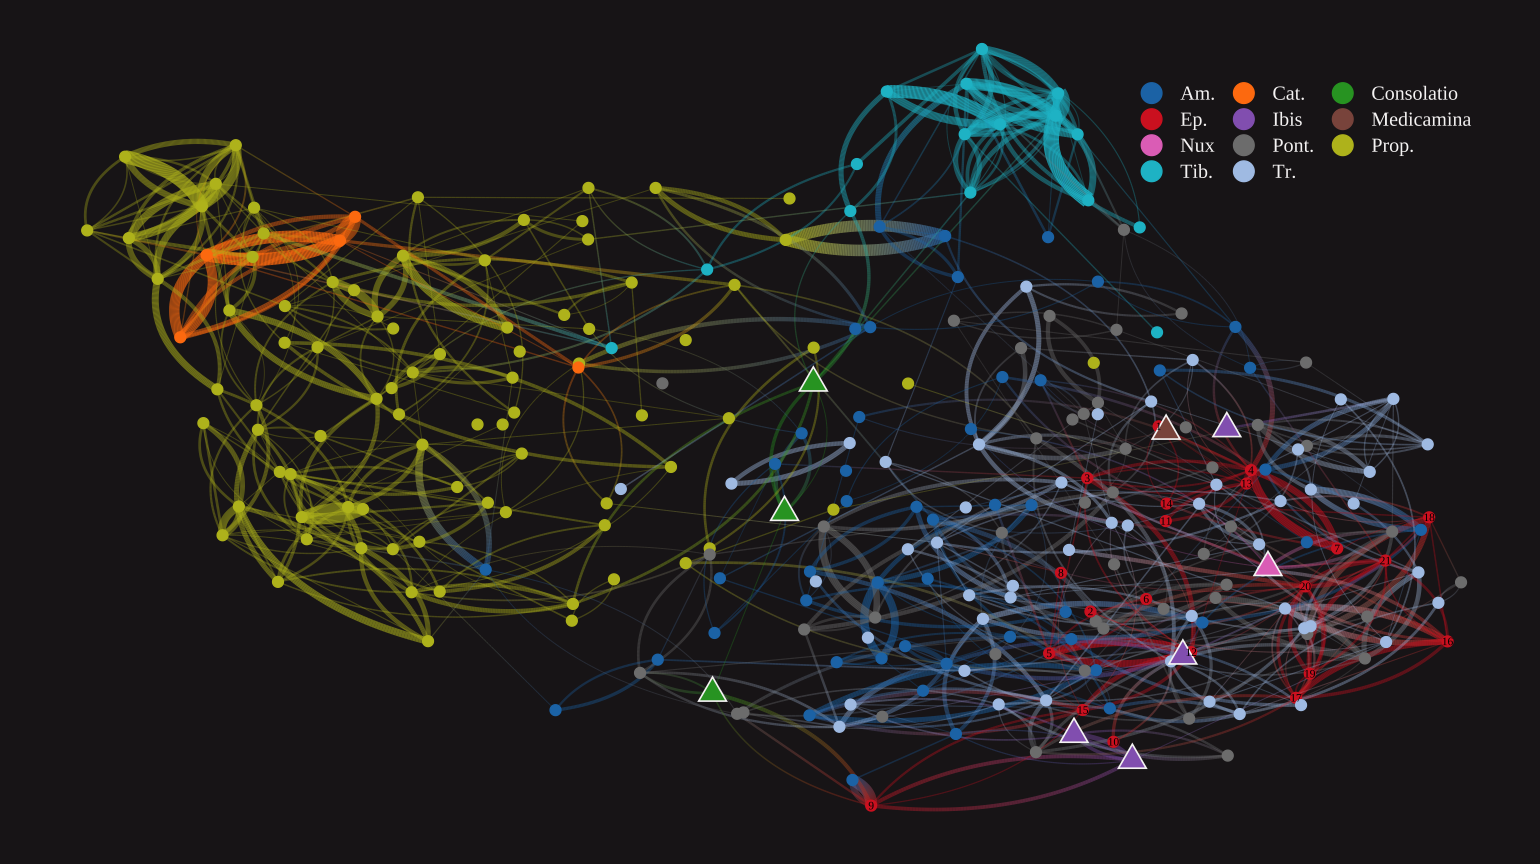

In [32]:
%%R -i graph_trim  -h 6 -w 10.7 -u in -r 144

source('do_bct.R')
p <- do_bct(
    graph_trim,
    '#f6f5f5',
    '#1e1a1d',
    lim=150,
    highlight_nodes=c("Nux", "Ibis", "Consolatio", "Medicamina"),
    number_nodes=c("Ep."),
    legend_pos = c(0.85,0.85),
    flip=TRUE
)
# fn <- "bct_ngram.pdf"
# ggsave(plot=p, fn, dpi=600, width=10.7, height=6, device=cairo_pdf)
p